## Objectif du TD N°1 interpretable Machine Learning


Ce td vise à interpréter les modèles de machine learning que vous avez crées lors du TD N°2 SVM.

Vous chercherez à interpréter globalement votre modèle avec les méthodes vues en cours et surtout examiner la différence entre des modèles linéaires et non linéaires.


## Enoncé du TD

### Importer le modèle du TD N°2

1. Importer le jeu de données breast cancer disponible dans le module sklearn.datasets
2. Importer un modèle non linéaire utilisé lors du TD N°2 ou alors recréer l'ensemble de la pipeline visant à le générer
3. Vérifier que votre modèle réalise correctement une prédiction pour un individu


### Comparer interprétation des coéfficients et méthode globale

4. Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats
5. Utiliser maintenant les différentes méthodes d'interprétation de modèle avec les résultats de le résultats des coefficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 
6. Commenter

### Interpréter un modèle non linéaire

7. Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales
8. Commenter la différence de résultat






## Partie Code

#### 1)Importer le jeu de données breast cancer disponible dans le module sklearn.datasets

In [5]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import pickle

In [6]:
#Load dataset breast cancer
data = load_breast_cancer()

breast = pd.DataFrame(data = np.c_[data.data,data.target], columns=list(data.feature_names)+['target'] )
#Nom des colonnes et remplacer les espaces par un "_"
features_name = [name.replace(" ", "_") for name in data.feature_names]
breast.columns= features_name+['target']

In [7]:
# On inverse la modalité de référence
breast.target = 1- breast.target

#### 2) Recréer l'ensemble de la pipeline visant à générer un SVM non linéaire (RBF ou degree >1)


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Séparer les caractéristiques et la cible
X = breast.drop(columns=['target'])
y = breast['target']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
model_pref = SVC(random_state=42, C=0.5, kernel='poly',degree=2)

In [12]:
model_pref.fit(X_train, y_train)

SVC(C=0.5, degree=2, kernel='poly', random_state=42)

#### 3) Vérifier que votre modèle réalise correctement une prédiction pour un individu

In [ ]:
# Sélectionner un individu de l'ensemble de test
individu = X_test.iloc[0]

# Réaliser une prédiction
prediction = model_pref.predict([individu])
print({prediction[0]})

{0.0}


c:\Users\lilou\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


#### 4) Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats

Ici, l'idée est de mobiliser vos connaissance du modèle de régression logistique et d'interpréter les effets des variables.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Créer le modèle de régression logistique
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Entraîner le modèle sur les données d'entraînement
log_reg.fit(X_train, y_train)

# Prédire les étiquettes pour les données de test
y_pred = log_reg.predict(X_test)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97        71
         1.0       0.97      0.91      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [21]:
# Extraire les coefficients du modèle de régression logistique
coefficients = log_reg.coef_[0]

# Créer un DataFrame pour afficher les coefficients avec les noms des caractéristiques
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Trier les coefficients par ordre décroissant de leur valeur absolue
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

# Afficher le DataFrame
coef_df

,Feature,Coefficient
26,worst_concavity,1.441167
11,texture_error,-1.355114
0,mean_radius,-0.981506
28,worst_symmetry,0.749504
25,worst_compactness,0.731010
6,mean_concavity,0.537999
27,worst_concave_points,0.521857
21,worst_texture,0.510680
2,mean_perimeter,0.365492
24,worst_smoothness,0.320962


#Quand mean_radius augmente la probabilité que la tumeur soit maligne baisse ?  ce n'est pas logique 

#### 5) Utiliser maintenant les différentes méthodes d'interprétations de modèle avec les résultats de le résultats des coéfficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 

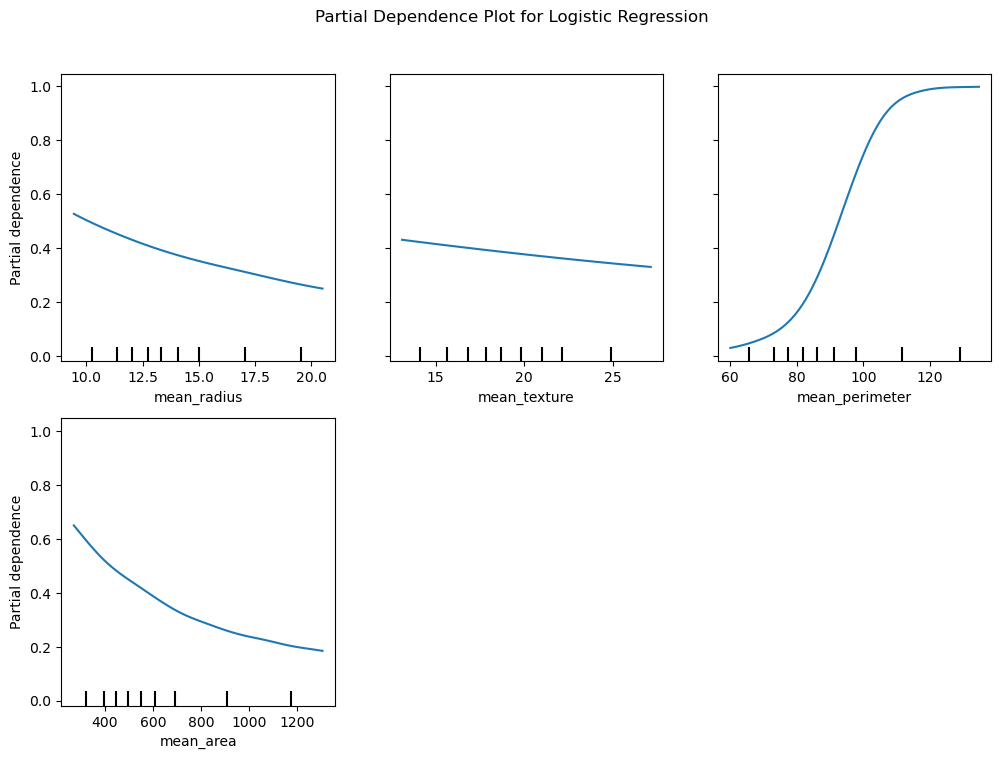

In [30]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Sélectionner les caractéristiques pour lesquelles vous souhaitez tracer le PDP
features = ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area']

# Créer le PDP pour le modèle de régression logistique
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(log_reg, X_train, features, ax=ax)
plt.suptitle('Partial Dependence Plot for Logistic Regression')
plt.subplots_adjust(top=0.9)  # Ajuster l'espace pour le titre
plt.show()

#cela va avec l'analyse du dessus, mais cela ne reste pas "logique". PLus on s'apporhce de la valeur moyenne on baisse d'avoir une tumeur maligne

In [32]:
!pip install alibi
from alibi.explainers import ALE

# Créer l'explainer ALE pour le modèle de régression logistique
ale_explainer = ALE(log_reg, feature_names=X.columns.tolist(), target_names=['benign', 'malignant'])

# Calculer les effets ALE
ale_exp = ale_explainer.explain(X_train.values)

# Tracer les effets ALE
fig, ax = plt.subplots(figsize=(12, 8))
for i, feature in enumerate(features):
    ax = plt.subplot(2, 2, i + 1)
    ax.plot(ale_exp.ale_values[feature], label=feature)
    ax.set_title(f'ALE Plot for {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('ALE')
    ax.legend()

plt.tight_layout()
plt.show()

  Obtaining dependency information for alibi from https://files.pythonhosted.org/packages/bc/00/bc8caafbabf675a15f08e8cd6d86eedb5949e2cec5ec73157d71f62abd79/alibi-0.9.6-py3-none-any.whl.metadata
  Obtaining dependency information for spacy[lookups]<4.0.0,>=2.0.0 from https://files.pythonhosted.org/packages/ca/45/7b43e89b30fe73e32fd8b8ab80c407d326761530a88abd823ec8623772a6/spacy-3.8.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for blis<0.8.0 from https://files.pythonhosted.org/packages/2f/09/da0592c74560cc33396504698122f7a56747c82a5e072ca7d2c3397898e1/blis-0.7.11-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for spacy-legacy<3.1.0,>=3.0.11 from https://files.pythonhosted.org/packages/c3/55/12e842c70ff8828e34e543a2c7176dac4da006ca6901c9e8b43efab8bc6b/spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata
  Obtaining dependency information for spacy-loggers<2.0.0,>=1.0.0 from https://files.pythonhosted.org/packages/33/78/d1a1a026ef3af911159398

TypeError: 'LogisticRegression' object is not callable

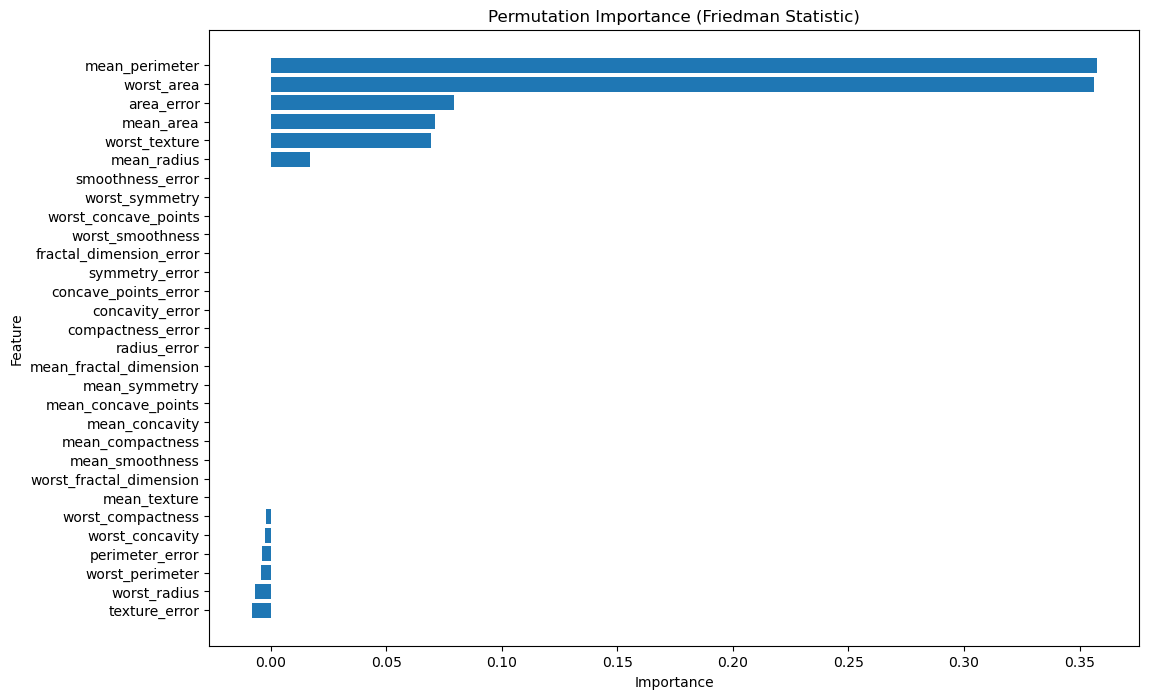

In [35]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance for the logistic regression model
result = permutation_importance(log_reg, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Create a DataFrame to display the feature importances
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})

# Sort the DataFrame by importance
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance (Friedman Statistic)')
plt.gca().invert_yaxis()
plt.show()

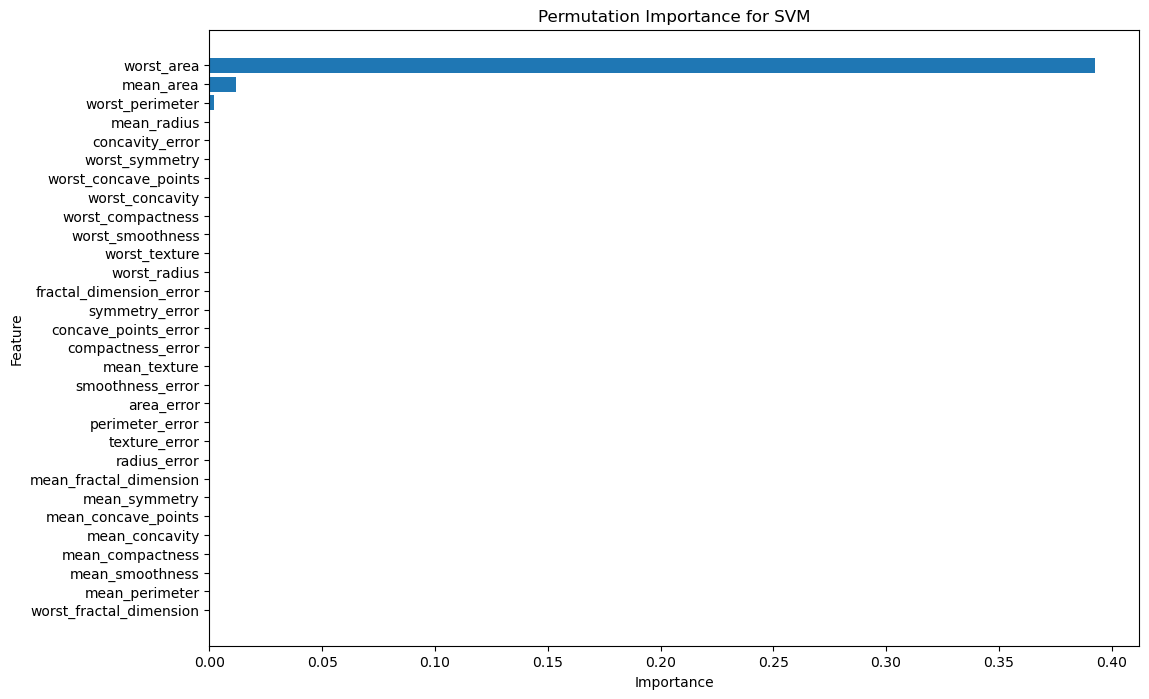

In [36]:
# Calculate permutation importance for the SVM model
result_svm = permutation_importance(model_pref, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Create a DataFrame to display the feature importances
perm_importance_svm_df = pd.DataFrame({'Feature': X.columns, 'Importance': result_svm.importances_mean})

# Sort the DataFrame by importance
perm_importance_svm_df = perm_importance_svm_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(perm_importance_svm_df['Feature'], perm_importance_svm_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance for SVM')
plt.gca().invert_yaxis()
plt.show()